In [334]:
import numpy as np
from operator import add
from matplotlib import pyplot as plt
import pandas

In [335]:
######################################### 2.1 #########################################
# function to get all possible equilibrium Y points combination
def get_all_equil_Y(num_firm):
    if num_firm == 1:
        return [[0],[1]]
    all_equil_Y = []
    temp = get_all_equil_Y(num_firm-1)
    for i in range(2):
        for j in range(len(temp)):
            all_equil_Y.append(temp[j]+[i])
    return all_equil_Y

In [336]:
# firm class
class Firm:
    def __init__(self, a, d, e, order):
        self.alpha = a
        self.delta = d
        self.epsilon = e
        self.order = order

# check 1 equilibrium for 1 firm
def Check_1equil_1firm(myfirm,list_Y):
    firm_Y = list_Y[myfirm.order]
    if (firm_Y == 1) and (myfirm.alpha+myfirm.delta*(sum(list_Y)-firm_Y)+myfirm.epsilon >= 0):
        return True
    if (firm_Y == 0) and (myfirm.alpha+myfirm.delta*(sum(list_Y)-firm_Y)+myfirm.epsilon < 0):
        return True
    return False

# check 1 equilibrium for n firm
def Check_1equil_nfirm(list_firm,list_Y):
    for i in range(len(list_firm)):
        if Check_1equil_1firm(list_firm[i],list_Y) == False:
            return False
    return True

# check n equilibrium for n firm
def Check_nequil_nfirm(list_firm,all_lists_Y):
    count= [0 for i in range(len(all_lists_Y))]
    for j in range(len(all_lists_Y)):
        if Check_1equil_nfirm(list_firm,all_lists_Y[j]):
            count[j] = 1
    return count

In [352]:
s2 = 10
r = 0.4
mean = [0,0]
cov = [ [s2,s2*r],
        [s2*r,s2] ]

# for 2 firms, calculate 
# P(Y=y)
# (i) Ciliberto and Tamer bound = [P(e st y unique equil), P(e st y unique equil)+P(e st y multi equil)]
# (ii) P(e st k equil)
# (iii) Artstein's inequalities (total 5)
    #P(Y=y)>=P(e st y) where singleton y (4)
    #P(Y=01/10)>=P(e st equil =01/10)

def get_P_2firm (num_firm, num_simulation, para_alpha, para_delta):

    # initialize vectors
    all_firm = []                                                                # all firm
    all_equil_Y = get_all_equil_Y(num_firm)                                      # Y=y for all y
    P_count = [0 for i in range(len(all_equil_Y))]                               # P(Y=y) for all y
    CT_Y_bound = [[0 for i in range(2)] for j in range(len(all_equil_Y))]        # [P(y uniq equil), P(y uniq equil)+P(y multi equil)]
    P_NY_count = [0 for i in range( ( num_firm+1 ) )]                            # P(k equil) for all k
    P_union_count = [0 for i in range(5)]                                        # P(equil=01/10)
    
    # initialize all firm with temporary e=0
    for i in range(num_firm):
        all_firm.append(Firm(para_alpha[i],para_delta[i],0,i))

    # change e, for each e, get equil and bound
    for t in range(num_simulation):
        e = np.random.multivariate_normal(mean, cov).T
        
        # put e into each firm
        for i in range(len(all_firm)):
            all_firm[i].epsilon = e[i]
        
        # get equil
        count = Check_nequil_nfirm(all_firm,all_equil_Y)
        sum_count = sum(count)
       
        # temporary (ii) P(k equil) by counting
        if count[0] == 1:
            P_NY_count[0] = P_NY_count[0] + 1
        if count[1] == 1 or count[2] == 1:
            P_NY_count[1] = P_NY_count[1] + 1
        if count[3] == 1:
            P_NY_count[2] = P_NY_count[2] + 1
        
        # temporary (iii) P(equil=01/10) by counting
        if (sum_count - count[0]) == 0:
            P_union_count[0] = P_union_count[0] + 1
        if (sum_count - count[1]) == 0:
            P_union_count[1] = P_union_count[1] + 1
        if (sum_count - count[2]) == 0:
            P_union_count[2] = P_union_count[2] + 1
        if (sum_count - count[3]) == 0:
            P_union_count[3] = P_union_count[3] + 1
        if (sum_count - count[1] - count[2]) == 0:
            P_union_count[4] = P_union_count[4] + 1
        
        # temporary (i) [P(y uniq equil), P(y uniq equil)+P(y multi equil)] by counting
        if sum_count == 1:     # unique equil
            for i in range(len(all_equil_Y)):
                if count[i]==1:
                    CT_Y_bound[i][0] = CT_Y_bound[i][0] + 1
                    CT_Y_bound[i][1] = CT_Y_bound[i][1] + 1
        if sum_count > 1:      # multi equil
            for i in range(len(all_equil_Y)):
                if count[i]==1:
                    CT_Y_bound[i][1] = CT_Y_bound[i][1] + 1
            for i in range(len(all_equil_Y)):
                count[i] = count[i]/sum_count     # select from multiplicity with equal prob
        # temporary P(Y=y) by counting
        P_count = [P_count[i] + count[i] for i in range(len(count))]
        # the end for one e iteration
    
    # true P(Y=y), CT bound, P(e st k equil), P(e st equil =01/10) by probability
    P_count = [val/num_simulation for val in P_count]
    for i in range(len(all_equil_Y)):
        CT_Y_bound[i][0] = CT_Y_bound[i][0]/num_simulation
        CT_Y_bound[i][1] = CT_Y_bound[i][1]/num_simulation
    P_NY_count = [val/num_simulation for val in P_NY_count]   
    P_union_count = [val/num_simulation for val in P_union_count]    

    return(P_count,CT_Y_bound,P_NY_count,P_union_count)

In [364]:
# final answer to 2.1 
# true parameters alpha = [1,1], delta = [-1,-1], P(Y=[00,10,01,11])=[0.202, 0.2438, 0.2421, 0.3121]
true_val = get_P_2firm(2,10000,[1,1],[-1,-1])
print(true_val[0],"\n",
      true_val[1],"\n",
      true_val[2],"\n",
      true_val[3])
# lists to store compatible parameters alpha and delta
compatible_a_CT = []
compatible_d_CT = []

compatible_a_equal = []
compatible_d_equal = []

compatible_a_art = []
compatible_d_art = []

[0.1954, 0.2455, 0.248, 0.3111] 
 [[0.1954, 0.1954], [0.2375, 0.2535], [0.24, 0.256], [0.3111, 0.3111]] 
 [0.1954, 0.4935, 0.3111] 
 [0.1954, 0.2375, 0.24, 0.3111, 0.4935]


In [365]:
######################################### 2.2 #########################################
# search 
for m in np.arange(0.8,1.2,0.025):
    for n in np.arange(-1.2,-0.8,0.025):
        print(m,n)
        a_guess = [m,m]
        d_guess = [n,n]
        P_guess = get_P_2firm(2,8000,a_guess,d_guess)
        
        # check (i)
        flag_CT = True
        for i in range(len(true_val[0])):
            if true_val[0][i] < (P_guess[1][i][0] - 1e-2) or true_val[0][i] > (P_guess[1][i][1]+1e-2):
                flag_CT = False
                break
        if flag_CT:
            print("yes CT")
            compatible_a_CT.append(m)
            compatible_d_CT.append(n)
        
        # check (ii)
        flag_equal = True
        if abs(true_val[0][0]- P_guess[2][0]) > 1e-2:
            flag_equal = False
        if abs(true_val[0][1]+true_val[0][2]- P_guess[2][1]) > 1e-2:
            flag_equal = False
        if abs(true_val[0][3]- P_guess[2][2]) > 1e-2:
            flag_equal = False
        if flag_equal:
            print("yes equal")
            compatible_a_equal.append(m)
            compatible_d_equal.append(n)
            
        # check (iii)
        flag_art = True
        if abs(true_val[0][0]-P_guess[3][0])>1e-2:
            flag_art = False
        if true_val[0][1]<P_guess[3][1]:
            flag_art = False
        if true_val[0][2]<P_guess[3][2]:
            flag_art = False
        if abs(true_val[0][3]-P_guess[3][3])>1e-2:
            flag_art = False
        if abs(true_val[0][1] + true_val[0][2]  - P_guess[3][4])>1e-2:
            flag_art = False
        if flag_art:
            print("yes art")
            compatible_a_art.append(m)
            compatible_d_art.append(n)
print("end")

0.8 -1.2
0.8 -1.175
0.8 -1.1500000000000001
0.8 -1.1250000000000002
0.8 -1.1000000000000003
0.8 -1.0750000000000004
0.8 -1.0500000000000005
0.8 -1.0250000000000006
0.8 -1.0000000000000007
0.8 -0.9750000000000008
0.8 -0.9500000000000008
0.8 -0.9250000000000009
0.8 -0.900000000000001
0.8 -0.8750000000000011
0.8 -0.8500000000000012
0.8 -0.8250000000000013
0.8250000000000001 -1.2
0.8250000000000001 -1.175
0.8250000000000001 -1.1500000000000001
0.8250000000000001 -1.1250000000000002
0.8250000000000001 -1.1000000000000003
0.8250000000000001 -1.0750000000000004
0.8250000000000001 -1.0500000000000005
0.8250000000000001 -1.0250000000000006
0.8250000000000001 -1.0000000000000007
0.8250000000000001 -0.9750000000000008
0.8250000000000001 -0.9500000000000008
0.8250000000000001 -0.9250000000000009
0.8250000000000001 -0.900000000000001
0.8250000000000001 -0.8750000000000011
0.8250000000000001 -0.8500000000000012
0.8250000000000001 -0.8250000000000013
0.8500000000000001 -1.2
0.8500000000000001 -1.175


1.1000000000000003 -0.8750000000000011
1.1000000000000003 -0.8500000000000012
1.1000000000000003 -0.8250000000000013
1.1250000000000004 -1.2
1.1250000000000004 -1.175
1.1250000000000004 -1.1500000000000001
yes CT
yes equal
yes art
1.1250000000000004 -1.1250000000000002
1.1250000000000004 -1.1000000000000003
1.1250000000000004 -1.0750000000000004
1.1250000000000004 -1.0500000000000005
1.1250000000000004 -1.0250000000000006
1.1250000000000004 -1.0000000000000007
1.1250000000000004 -0.9750000000000008
1.1250000000000004 -0.9500000000000008
1.1250000000000004 -0.9250000000000009
1.1250000000000004 -0.900000000000001
1.1250000000000004 -0.8750000000000011
1.1250000000000004 -0.8500000000000012
1.1250000000000004 -0.8250000000000013
1.1500000000000004 -1.2
yes CT
1.1500000000000004 -1.175
1.1500000000000004 -1.1500000000000001
1.1500000000000004 -1.1250000000000002
1.1500000000000004 -1.1000000000000003
1.1500000000000004 -1.0750000000000004
yes CT
yes equal
yes art
1.1500000000000004 -1.050

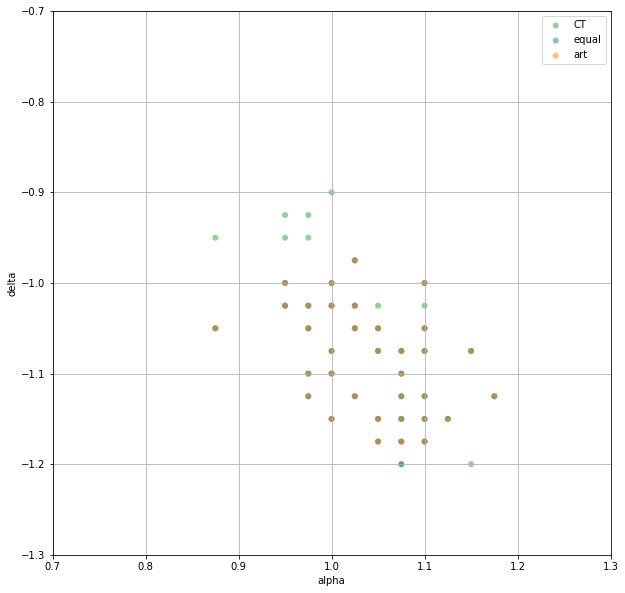

In [370]:
# 2.2 final answer graph 1
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(compatible_a_CT, compatible_d_CT,label="CT",c='tab:green',alpha=0.5, edgecolors='none')
ax.scatter(compatible_a_equal, compatible_d_equal,label="equal",c='tab:blue',alpha=0.5, edgecolors='none')
ax.scatter(compatible_a_art, compatible_d_art,label="art",c='tab:orange',alpha=0.5, edgecolors='none')
ax.legend()
ax.set_xlim([0.7, 1.3])
ax.set_ylim([-1.3, -0.7])
ax.grid(True)
ax.set_xlabel('alpha')
ax.set_ylabel('delta')

plt.savefig('2firm_1.png', dpi=300)

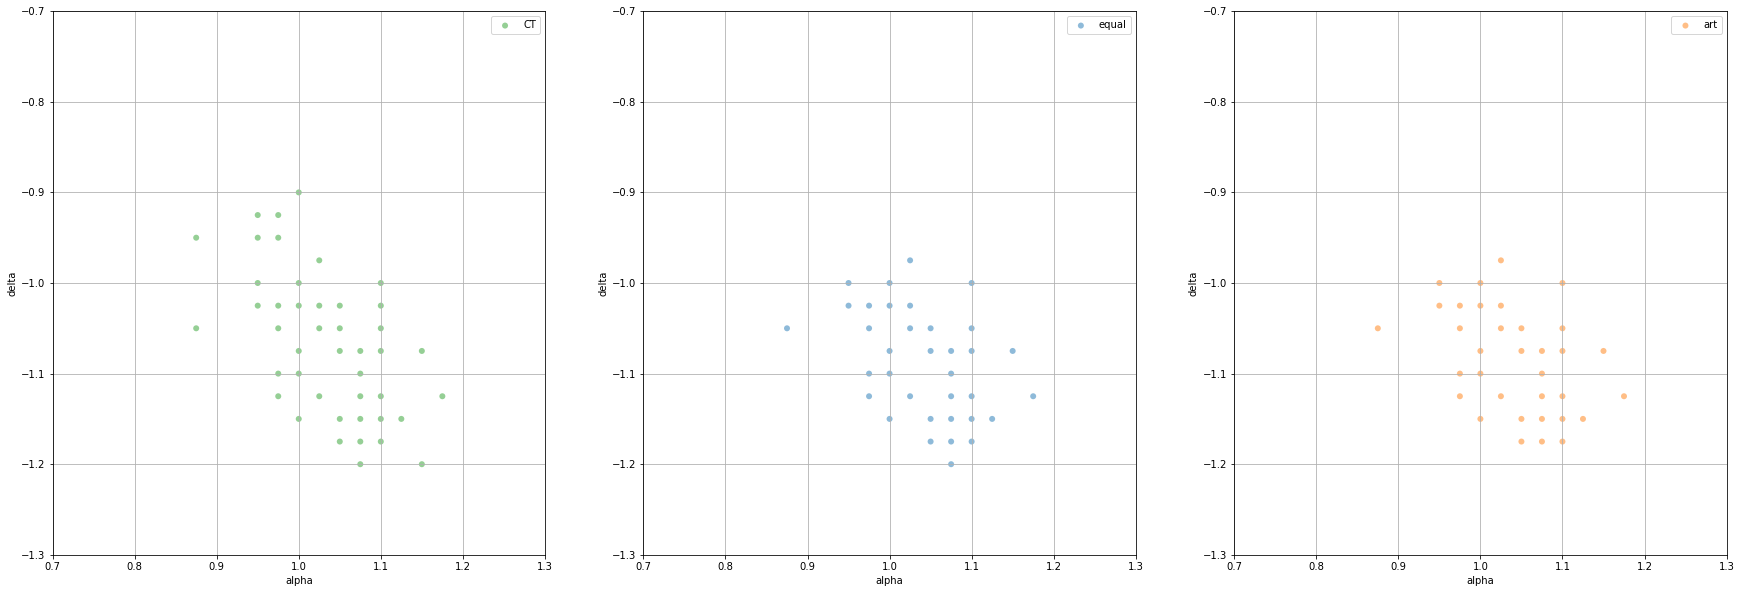

In [371]:
# 2.2 final answer graph 2
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(30)
ax1.scatter(compatible_a_CT, compatible_d_CT,label="CT",c='tab:green',alpha=0.5, edgecolors='none')
ax2.scatter(compatible_a_equal, compatible_d_equal,label="equal",c='tab:blue',alpha=0.5, edgecolors='none')
ax3.scatter(compatible_a_art, compatible_d_art,label="art",c='tab:orange',alpha=0.5, edgecolors='none')

for ax in [ax1,ax2,ax3]:    
    ax.legend()
    ax.set_xlim([0.7, 1.3])
    ax.set_ylim([-1.3, -0.7])
    ax.grid(True)
    ax.set_xlabel('alpha')
    ax.set_ylabel('delta')

plt.savefig('2firm_2.png', dpi=300)

In [368]:
######################################### 2.3 #########################################
s2 = 20
r = 0.5
mean = [0,0,0]
cov = [ 
    [s2, s2*r, s2*r],
    [s2*r, s2, s2*r],
    [s2*r, s2*r, s2]
      ]


# for 3 firms, calculate 
# P(Y=y)
# (i) Ciliberto and Tamer bound = [P(e st y unique equil), P(e st y unique equil)+P(e st y multi equil)]
# (ii) P(e st k equil)
# (iii) Artstein's inequalities (total 16)
    #P(Y=y)>=/=P(e st y) where singleton y (8)
    #P(Y= 100/010)>=P(e st equil =)
    #P(Y= 100/001)>=P(e st equil =)
    #P(Y= 010/001)>=P(e st equil =)
    #P(Y= 100/010/001)>=P(e st equil =)
    
    #P(Y= 110/101)>=P(e st equil =)
    #P(Y= 110/011)>=P(e st equil =)
    #P(Y= 101/011)>=P(e st equil =)
    #P(Y= 110/101/011)>=P(e st equil =)
    
def get_P_3firm (num_firm, num_simulation, para_alpha, para_delta):

    # initialize vectors
    all_firm = []                                                                # all firm
    all_equil_Y = get_all_equil_Y(num_firm)                                      # Y=y for all y
    P_count = [0 for i in range(len(all_equil_Y))]                               # P(Y=y) for all y
    CT_Y_bound = [[0 for i in range(2)] for j in range(len(all_equil_Y))]        # [P(y uniq equil), P(y uniq equil)+P(y multi equil)]
    P_NY_count = [0 for i in range( ( num_firm+1 ) )]                            # P(k equil) for all k
    P_union_count = [0 for i in range(16)]                                        # P(equil=100/010)...
    
    # initialize all firm with temporary e=0
    for i in range(num_firm):
        all_firm.append(Firm(para_alpha[i],para_delta[i],0,i))

    # change e, for each e, get equil and bound
    for t in range(num_simulation):
        e = np.random.multivariate_normal(mean, cov).T
        
        # put e into each firm
        for i in range(len(all_firm)):
            all_firm[i].epsilon = e[i]
        
        # get equil
        count = Check_nequil_nfirm(all_firm,all_equil_Y)
        sum_count = sum(count)
        
        # temporary (ii) P(k equil) by counting
        for i in range(len(all_equil_Y)):
            if count[i] == 1:
                temp = sum(all_equil_Y[i])
                P_NY_count[temp] = P_NY_count[temp] + 1
                break
        
        # temporary (iii) P(equil=01/10) by counting
        for i in range(len(all_equil_Y)):
            if (sum_count - count[i]) == 0:
                P_union_count[i] = P_union_count[i] + 1
        
        if (sum_count - count[1]-count[2] == 0):
            P_union_count[8] = P_union_count[8] + 1
        if (sum_count - count[1]-count[4] == 0):
            P_union_count[9] = P_union_count[9] + 1
        if (sum_count - count[2]-count[4] == 0):
            P_union_count[10] = P_union_count[10] + 1
        if (sum_count - count[1]-count[2]-count[4] == 0):
            P_union_count[11] = P_union_count[11] + 1
        
        if (sum_count - count[3]-count[5] == 0):
            P_union_count[12] = P_union_count[12] + 1
        if (sum_count - count[3]-count[6] == 0):
            P_union_count[13] = P_union_count[13] + 1
        if (sum_count - count[5]-count[6] == 0):
            P_union_count[14] = P_union_count[14] + 1
        if (sum_count - count[3]-count[5]-count[6] == 0):
            P_union_count[15] = P_union_count[15] + 1
      
        # temporary (i) [P(y uniq equil), P(y uniq equil)+P(y multi equil)] by counting
        if sum_count == 1:     # unique equil
            for i in range(len(all_equil_Y)):
                if count[i]==1:
                    CT_Y_bound[i][0] = CT_Y_bound[i][0] + 1
                    CT_Y_bound[i][1] = CT_Y_bound[i][1] + 1
        if sum_count > 1:      # multi equil
            for i in range(len(all_equil_Y)):
                if count[i]==1:
                    CT_Y_bound[i][1] = CT_Y_bound[i][1] + 1
            for i in range(len(all_equil_Y)):
                count[i] = count[i]/sum_count     # select from multiplicity with equal prob
        # temporary P(Y=y) by counting
        P_count = [P_count[i] + count[i] for i in range(len(count))]
        # the end for one e iteration
    
    # true P(Y=y), CT bound, P(e st k equil), P(e st equil =01/10) by probability
    P_count = [val/num_simulation for val in P_count]
    for i in range(len(all_equil_Y)):
        CT_Y_bound[i][0] = CT_Y_bound[i][0]/num_simulation
        CT_Y_bound[i][1] = CT_Y_bound[i][1]/num_simulation
    P_NY_count = [val/num_simulation for val in P_NY_count]   
    P_union_count = [val/num_simulation for val in P_union_count]    

    return(P_count,CT_Y_bound,P_NY_count,P_union_count) 

In [369]:
# true parameters alpha = [1,1,1], delta = [-1,-1,-1], P(Y=000/100/010/110/001/101/011/111)= [0.126, 0.12313333333333333, 0.1231333333333333, 0.12636666666666663, 0.12373333333333332, 0.12596666666666662, 0.12066666666666663, 0.131]
true_val_3 = get_P_3firm(3,10000,[1,1,1],[-1,-1,-1])
print(true_val_3[0],"\n",
      true_val_3[1],"\n",
      true_val_3[2],"\n",
      true_val_3[3])

# lists to store compatible parameters alpha and delta
compatible_a_CT_3 = []
compatible_d_CT_3 = []

compatible_a_equal_3 = []
compatible_d_equal_3 = []

compatible_a_art_3 = []
compatible_d_art_3 = []

[0.1825, 0.10571666666666665, 0.10416666666666667, 0.1077166666666667, 0.11381666666666665, 0.1067166666666667, 0.1039666666666667, 0.1754] 
 [[0.1825, 0.1825], [0.1022, 0.1095], [0.1008, 0.1078], [0.1038, 0.1118], [0.11, 0.1179], [0.1027, 0.1109], [0.0998, 0.1083], [0.1754, 0.1754]] 
 [0.1825, 0.3237, 0.3184, 0.1754] 
 [0.1825, 0.1022, 0.1008, 0.1038, 0.11, 0.1027, 0.0998, 0.1754, 0.2058, 0.2159, 0.2142, 0.3237, 0.2101, 0.2075, 0.2066, 0.3184]


In [372]:
# search 
for m in np.arange(0.8,1.2,0.025):
    for n in np.arange(-1.2,-0.8,0.025):
        print(m,n)
        a_guess = [m,m,m]
        d_guess = [n,n,n]
        P_guess = get_P_3firm(3,8000,a_guess,d_guess)
        
        # check (i)
        flag_CT = True
        for i in range(len(true_val_3[0])):
            if true_val_3[0][i] < (P_guess[1][i][0] - 1e-2) or true_val_3[0][i] > (P_guess[1][i][1]+1e-2):
                flag_CT = False
                break
        if flag_CT:
            print("yes CT")
            compatible_a_CT_3.append(m)
            compatible_d_CT_3.append(n)
        
        # check (ii)
        flag_equal = True
        if abs(true_val_3[0][0]- P_guess[2][0]) > 1e-2:
            flag_equal = False
        if abs(true_val_3[0][1]+true_val_3[0][2]+true_val_3[0][4]- P_guess[2][1]) > 1e-2:
            flag_equal = False
        if abs(true_val_3[0][3]+true_val_3[0][5]+true_val_3[0][6]- P_guess[2][2]) > 1e-2:
            flag_equal = False
        if abs(true_val_3[0][7]- P_guess[2][3]) > 1e-2:
            flag_equal = False
        if flag_equal:
            print("yes equal")
            compatible_a_equal_3.append(m)
            compatible_d_equal_3.append(n)
            
        # check (iii)
        flag_art = True        
        for i in [1,2,3,4,5,6]:
            if true_val_3[0][i] < P_guess[3][i]:
                flag_art = False
                break
        if flag_art:
            if abs(true_val_3[0][0]-P_guess[3][0]) > 1e-2:
                flag_art = False
            if abs(true_val_3[0][7]-P_guess[3][7]) > 1e-2:
                flag_art = False
            
            if true_val_3[0][1] + true_val_3[0][2]  < P_guess[3][8]:
                flag_art = False
            if true_val_3[0][1] + true_val_3[0][4]  < P_guess[3][9]:
                flag_art = False
            if true_val_3[0][2] + true_val_3[0][4]  < P_guess[3][10]:
                flag_art = False
            if abs(true_val_3[0][1] + true_val_3[0][2] + true_val_3[0][4] - P_guess[3][11]) >  1e-2:
                flag_art = False
            
            if true_val_3[0][3] + true_val_3[0][5]  < P_guess[3][12]:
                flag_art = False
            if true_val_3[0][3] + true_val_3[0][6]  < P_guess[3][13]:
                flag_art = False
            if true_val_3[0][5] + true_val_3[0][6]  < P_guess[3][14]:
                flag_art = False
            if abs(true_val_3[0][3] + true_val_3[0][5] + true_val_3[0][6]- P_guess[3][15] ) >  1e-2:
                flag_art = False 

        if flag_art:
            print("yes art")
            compatible_a_art_3.append(m)
            compatible_d_art_3.append(n) 
print("end")

0.8 -1.2
0.8 -1.175
0.8 -1.1500000000000001
0.8 -1.1250000000000002
0.8 -1.1000000000000003
0.8 -1.0750000000000004
0.8 -1.0500000000000005
0.8 -1.0250000000000006
0.8 -1.0000000000000007
yes CT
yes equal
0.8 -0.9750000000000008
0.8 -0.9500000000000008
0.8 -0.9250000000000009
yes CT
yes equal
yes art
0.8 -0.900000000000001
yes CT
yes equal
yes art
0.8 -0.8750000000000011
0.8 -0.8500000000000012
0.8 -0.8250000000000013
0.8250000000000001 -1.2
0.8250000000000001 -1.175
0.8250000000000001 -1.1500000000000001
0.8250000000000001 -1.1250000000000002
0.8250000000000001 -1.1000000000000003
0.8250000000000001 -1.0750000000000004
0.8250000000000001 -1.0500000000000005
0.8250000000000001 -1.0250000000000006
yes CT
yes equal
0.8250000000000001 -1.0000000000000007
yes CT
yes equal
0.8250000000000001 -0.9750000000000008
0.8250000000000001 -0.9500000000000008
yes CT
yes equal
yes art
0.8250000000000001 -0.9250000000000009
yes CT
0.8250000000000001 -0.900000000000001
yes CT
yes equal
0.825000000000000

1.1000000000000003 -0.9500000000000008
1.1000000000000003 -0.9250000000000009
1.1000000000000003 -0.900000000000001
1.1000000000000003 -0.8750000000000011
1.1000000000000003 -0.8500000000000012
1.1000000000000003 -0.8250000000000013
1.1250000000000004 -1.2
1.1250000000000004 -1.175
1.1250000000000004 -1.1500000000000001
1.1250000000000004 -1.1250000000000002
1.1250000000000004 -1.1000000000000003
yes CT
1.1250000000000004 -1.0750000000000004
1.1250000000000004 -1.0500000000000005
1.1250000000000004 -1.0250000000000006
1.1250000000000004 -1.0000000000000007
1.1250000000000004 -0.9750000000000008
1.1250000000000004 -0.9500000000000008
1.1250000000000004 -0.9250000000000009
1.1250000000000004 -0.900000000000001
1.1250000000000004 -0.8750000000000011
1.1250000000000004 -0.8500000000000012
1.1250000000000004 -0.8250000000000013
1.1500000000000004 -1.2
1.1500000000000004 -1.175
1.1500000000000004 -1.1500000000000001
1.1500000000000004 -1.1250000000000002
1.1500000000000004 -1.100000000000000

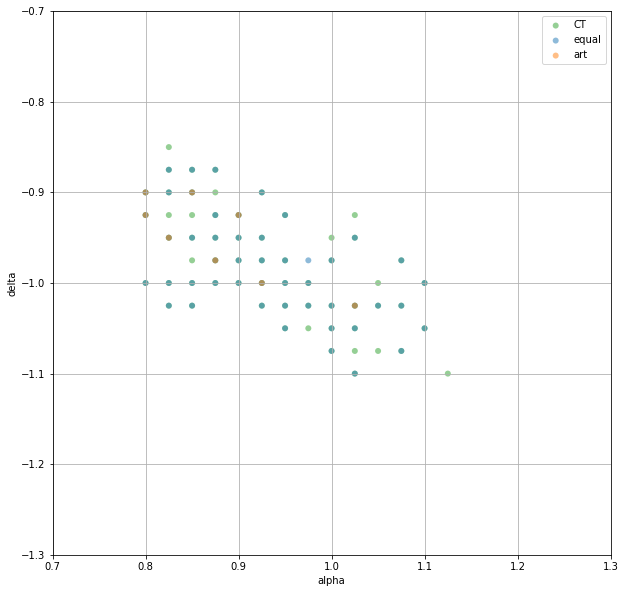

In [373]:
# 2.3 final answer graph 1
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(compatible_a_CT_3, compatible_d_CT_3,label="CT",c='tab:green',alpha=0.5, edgecolors='none')
ax.scatter(compatible_a_equal_3, compatible_d_equal_3,label="equal",c='tab:blue',alpha=0.5, edgecolors='none')
ax.scatter(compatible_a_art_3, compatible_d_art_3,label="art",c='tab:orange',alpha=0.5, edgecolors='none')
ax.legend()
ax.set_xlim([0.7, 1.3])
ax.set_ylim([-1.3, -0.7])
ax.grid(True)
ax.set_xlabel('alpha')
ax.set_ylabel('delta')

plt.savefig('3firm_1.png', dpi=300)

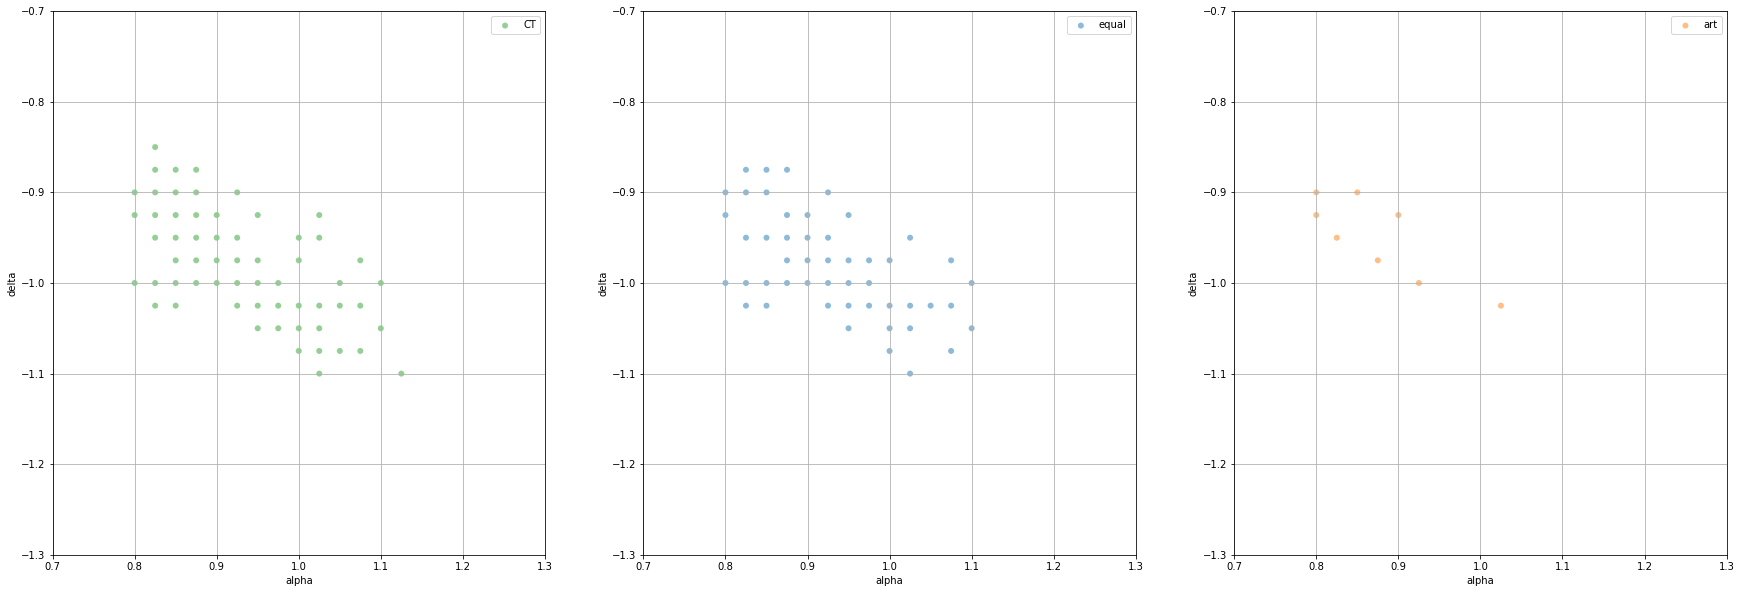

In [374]:
# 2.2 final answer graph 2
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(30)
ax1.scatter(compatible_a_CT_3, compatible_d_CT_3,label="CT",c='tab:green',alpha=0.5, edgecolors='none')
ax2.scatter(compatible_a_equal_3, compatible_d_equal_3,label="equal",c='tab:blue',alpha=0.5, edgecolors='none')
ax3.scatter(compatible_a_art_3, compatible_d_art_3,label="art",c='tab:orange',alpha=0.5, edgecolors='none')

for ax in [ax1,ax2,ax3]:    
    ax.legend()
    ax.set_xlim([0.7, 1.3])
    ax.set_ylim([-1.3, -0.7])
    ax.grid(True)
    ax.set_xlabel('alpha')
    ax.set_ylabel('delta')

plt.savefig('3firm_2.png', dpi=300)